In [2]:
import numpy as np
import scipy.stats
import scipy.optimize
import matplotlib.pyplot as plt

# iPython magic command for inline figures. If this command is not given, figures are generated in windows.
# An asterisk appears in the cell prompt (i.e. "In [*]:"), and the kernel stalls until the window is closed.
%matplotlib inline

## Below are two simple examples of exception handling

## Try to import pandas. If not existent, set flag = False, and raise an exception.
try:
    import pandas as pd
    pd_flag = True
except ImportError:
    print("Package pandas not found. Cannot do funky data structures!")
    pd_flag = False
    
## Try to import seaborn.
try:
    import seaborn as sns
    sns_flag = True
    sns.set_style("whitegrid")
    sns.set_style("ticks")
except ImportError:
    sns_flag = False
print("Does seaborn exist on the computer? " + str(sns_flag))

Does seaborn exist on the computer? True


##Maximum likelihood estimation with confidence intervals on the MLEs

We will now consider an example of how to fit data to obtain MLEs for the fit parameters, and also produce confidence intervals on those MLEs.  To start with we will set up this notebook with some of the useful functions which we used in Week 4:

In [3]:
### Import the scipy optimisation package
import scipy.optimize as op

###
### The two forms of the likelihood - note that the function LogLikelihood assumes normally distributed errors
###

def LogLikelihood(parm, xval, yval, dy): # the -ve log-likelihood
    ymod = my_model(xval, parm)  #We define our 'physical model' separately
    nd = scipy.stats.norm(ymod, dy) #we define our normal distribution
    return -sum(np.log(nd.pdf(yval)))

def ChiSq(parm, xval, yval, dy): # the weighted least-squares
    ymod = my_model(xval, parm)
    chisq = sum(pow((yval-ymod)/dy,2))
    return chisq

###
### And to convert significances from sigma to p and vice versa
###

def sigmas_to_p(sigval):
    nd = scipy.stats.norm(0., 1.)
    return 2.*nd.sf(sigval)

def p_to_sigmas(pval):
    nd = scipy.stats.norm(0., 1.)
# We use the 'inverse survival function', the inverse of the sf. We also need to divide
# our p-value by 2 to account for the negative side of the normal distribution.
    return nd.isf(pval/2.)

For this example we will use the linear part of the Reynolds fluid flow data which we used to demonstrate maximum likelihood estimation with a 2-parameter linear model in Week 4.  We will first set up the model and fit using weighted-least-squares and Nelder-Mead minimisation as in Week 4, producing as output the MLEs, chi-squared, degrees-of-freedom and also the goodness of fit:

In [4]:
reynolds = np.genfromtxt ("reynolds.txt", dtype=np.float, names=["dP", "v"], skip_header=1, autostrip=True)
## change units
ppm = 9.80665e3
dp = reynolds["dP"]*ppm
v = reynolds["v"]
## Now select the first 8 pairs of values, where the flow is laminar,
## and assign to x and y
xval = dp[0:8]
yval = v[0:8]
dy = 6.3e-3  ## We will assume a constant error for the purposes of this exercise

# parm is the vector of parameters, a (parm[0]) and b (parm[1])
def my_model(value, parm):
    return parm[0] + parm[1]*value

# First set the starting values of model parameters.  You should make sure
# these aren’t way off the expected values or the optimisation may get stuck
# - this doesn’t mean you need to know the values already, just choose something
# that seems plausible given the data.
parm = [0.01, 0.0035]
# Now the optimisation function: we can also change the function called to ChiSq
# without changing anything else, since the parameters are the same.
result = op.minimize(ChiSq, parm, args=(xval, yval, dy), method="Nelder-Mead")
a_mle, b_mle = result["x"]
mlval = result["fun"]

# Output the results
dof = len(xval)-len(parm)
print "Weighted least-squares fit results:"
print "Best-fitting intercept = " + str(a_mle) + " and gradient " + str(b_mle) + " with chi-squared = " + str(mlval)
print "for " + str(dof) + " d.o.f.."

# Output the goodness-of-fit
print "The goodness of fit of the linear model is: " + str(scipy.stats.chi2.sf(mlval, df=dof))

Weighted least-squares fit results:
Best-fitting intercept = 0.00751203430537 and gradient 0.00347096171654 with chi-squared = 5.99576886296
for 6 d.o.f..
The goodness of fit of the linear model is: 0.423664224004


### MLE confidence intervals from the covariance matrix: `fmin_bfgs`

We will now examine two approaches to estimate confidence intervals on the MLEs based on the <i>Hessian</i> (or equivalently, the <i>covariance matrix</i>).  In many cases we cannot easily determine the Hessian of our likelihood function analytically,
so the best approach is to do it numerically. Here the choice of optimiser is crucial. Some
optimisers already require knowledge of the Jacobian (or even the Hessian itself!), which we
often don't have. Others do not calculate Jacobians or Hessians at all. The best optimisers for
our purpose are ones which already calculate the first and second derivatives numerically and
so can output the Hessian that we require.  First we will consider the `fmin_bfgs` function.

In scipy's `optimize` package, the Nelder-Mead simplex algorithm is quite robust for minimisation problems but does not use any gradient evaluations so does not return the Hessian. Therefore, we use the `optimize` implementation of the Broyden-Fletcher-
Goldfarb-Shanno algorithm (BFGS) which does use numerical estimates of the gradient. The
`scipy.optimize.fmin_bfgs` minimisation routine does the job for us and even provides the inverse Hessian (i.e. the covariance matrix!) as output. The method can be a bit flakey however,
since it's search of the parameter space sometimes makes large jumps which may lead to infinities in the likelihood function (depending on how it is set up), which can cause the minimisation
process to stop. Therefore we must be careful to set things up so as to optimise our chances of
a good fit.

Let's assume that we have things set up as they were prior to minimisation of the
log-likelihood. Instead of using the `minimize` routine with Nelder-Mead, we will use `fmin_bfgs`
instead:

In [5]:
ml_pars, ml_funcval, ml_grad, ml_covar, func_calls, grad_calls, warnflag = \
scipy.optimize.fmin_bfgs(LogLikelihood, parm, args=(xval, yval, dy), full_output=True)

         Current function value: -28.913645
         Iterations: 0
         Function evaluations: 24
         Gradient evaluations: 3


This call should output the results of our minimisation to the variables given, however as you should notice, the
minimisation fails.

In [6]:
print ml_pars

[ 0.01    0.0035]


Our output parameters tell us that the minimisation has got stuck. To see what is going
wrong we can make our `LogLikelihood` function more verbose:

In [7]:
def LogLikelihood(parm, xval, yval, dy): # the -ve log-likelihood
    ymod = my_model(xval, parm)
    nd = scipy.stats.norm(ymod, dy) #we define our normal distribution
    print("nd: " + str(nd.pdf(yval)))
    ll= -sum(np.log(nd.pdf(yval)))
    print("LogLikelihood and parameters "+ str(ll),str(parm))
    return ll

ml_pars, ml_funcval, ml_grad, ml_covar, func_calls, grad_calls, warnflag = \
scipy.optimize.fmin_bfgs(LogLikelihood, parm, args=(xval, yval, dy), full_output=True)

nd: [ 57.12963257  63.32363253   6.09224008  35.91952165  48.46935515
  56.6844252   29.28654317  56.61125031]
('LogLikelihood and parameters -28.9136454097', '[ 0.01    0.0035]')
nd: [ 57.12957126  63.32363314   6.0922089   35.91961212  48.46927132
  56.68436209  29.28645714  56.61118692]
('LogLikelihood and parameters -28.9136348468', '[ 0.01000001  0.0035    ]')
nd: [ 57.12915154  63.32364212   6.09150929  35.9223519   48.4660832
  56.68146682  29.28183587  56.60728374]
('LogLikelihood and parameters -28.9132454564', '[ 0.01        0.00350001]')
nd: [ 57.12963257  63.32363253   6.09224008  35.91952165  48.46935515
  56.6844252   29.28654317  56.61125031]
('LogLikelihood and parameters -28.9136454097', '[ 0.01    0.0035]')
nd: [ 0.  0.  0.  0.  0.  0.  0.  0.]
('LogLikelihood and parameters inf', '[  -708.8541808  -26840.40717314]')
nd: [ 0.  0.  0.  0.  0.  0.  0.  0.]
('LogLikelihood and parameters inf', '[  -708.8541808  -26840.40717314]')
nd: [ 0.  0.  0.  0.  0.  0.  0.  0.]
('L

Now we run `fmin_bfgs` again and we see that the problem arises as the parameters jump to large negative values, leading to zero probabilities (within numerical precision) and hence a problem
with the log-likelihood. One way to fix this is to force the parameters to take on only certain values. E.g. if we instead make the parameters used equal to the logarithm of our parameters $a$ or $b$, we restrict the range of values used for $a$ or $b$ to only be positive.  We can also add some other rules to deal with other exceptions:

In [8]:
parm = np.log([0.01,0.0035])

def LogLikelihood(parm, xval, yval, dy): # the -ve log-likelihood
    logmax = 1.e12 # sets a maximum acceptable value for the -ve log-likelihood
    parm_new = np.exp(np.array(parm))
    ymod = my_model(xval, parm_new)
    nd = scipy.stats.norm(ymod, dy) #we define our normal distribution
    ll = -sum(np.log(nd.pdf(yval)))
    if np.isinf(ll) or np.isnan(ll): # This catches our infinities or nans
        print("I am here")
        print("parm: " + str(parm))
        return logmax
    else:
        return ll
    
ml_pars, ml_funcval, ml_grad, ml_covar, func_calls, grad_calls, warnflag = \
scipy.optimize.fmin_bfgs(LogLikelihood, parm, args=(xval, yval, dy), full_output=True)

### To output remember to convert back from log to linear:
print np.exp(ml_pars)

         Current function value: -30.188265
         Iterations: 7
         Function evaluations: 84
         Gradient evaluations: 18
[ 0.00752052  0.0034705 ]


With this redefined log-likelihood the BFGS minimisation is successful (as can be seen by comparing our MLEs with those obtained earlier using the robust Nelder-Mead approach). Note however that if we thought that one or more of our parameters might actually be negative, we might need to try
a different approach. To get the errors (1-sigma confidence intervals) for $\log{\left(a\right)}$ and $\log{\left(b\right)}$ we just need the square roots of the diagonals of the covariance matrix returned by `fmin_bfgs` (which are the variances). We can also convert our errors from the log to linear values with standard propagation of errors i.e. using $y = \exp{\left(x\right)}$ so
that $\Delta{y}=\frac{\mathrm{d}y}{\mathrm{d}x}\Delta{x}=\exp{\left(x\right)}\Delta{x}$.

In [9]:
err = np.sqrt(np.diag(ml_covar))
lin_err = err * np.exp(ml_pars)
print("a = " + str(np.exp(ml_pars[0])) + " +/- " + str(lin_err[0]))
print("b = " + str(np.exp(ml_pars[1])) + " +/- " + str(lin_err[1]))

a = 0.0075205167923 +/- 0.00486845119017
b = 0.00347050360687 +/- 0.000123046171379


The MLEs and their 1-sigma confidence intervals are too high in precision given the size of the errors, so it would be better to round them off following the rule-of-thumb suggested in the Week 1 tutorial, i.e. to 2 s.f. in the error and then the corresponding number of decimal places in the MLE itself.

### MLE confidence intervals from the covariance matrix: `curve_fit`

The `fmin_bfgs` minimiser has the advantage that requires no implicit assumption about how the errors on the data points (i.e. the errors on the $y$-values) are distributed - e.g. are they normal or not?).  In many cases however, the errors on the data <i>are</i> normally distributed and in those situations, not only can we use weighted least-squares for the likelihood statistic, but we can also use more specialised and robust mimimisation methods such as the `curve_fit` function in `scipy.optimize`.  The `curve_fit` routine uses non-linear least-squares to fit a function to data (i.e. it is not restrictied to linear least-square fitting) and if the error bars are provided it will carry out a weighted-least-squares fit, which is what we need to obtain a goodness-of-fit as well as confidence intervals.  As well as returning the best-fitting parameters (the MLEs), `curve_fit` also returns the covariance matrix evaluated at the minimum, which can be used as for `fmin_bfgs` above. 

In [10]:
### We define a new model function here since curve_fit requires parameters to be listed spearately
def my_cfmodel(value, a, b): 
    return a + b*value

p0 = [0.01, 0.0035]  # Define starting values
ml_cfpars, ml_cfcovar = scipy.optimize.curve_fit(my_cfmodel, xval, yval, p0, sigma=dy)
err = np.sqrt(np.diag(ml_cfcovar))

print "a = " + str(ml_cfpars[0]) + " +/- " + str(err[0])
print "b = " + str(ml_cfpars[1]) + " +/- " + str(err[1])

### curve_fit does not return the minimum chi-squared so we must calculate that ourselves for the MLEs
### obtained by the fit, e.g. using our original ChiSq function 
print "Minimum Chi-squared = " + str(ChiSq(ml_cfpars,xval,yval,dy)) + " for " + str(len(xval)-len(p0)) + " d.o.f."

a = 0.00752051424807 +/- 0.00490562168423
b = 0.00347050367447 +/- 0.0001242909418
Minimum Chi-squared = 5.99574356054 for 6 d.o.f.


Again, as above, you should round off the MLEs and errors appropriately when you present the final results!

We can compare the MLEs and errors for `curve_fit` and `fmin_bfgs`, e.g. to check that the transformation used to get a sensible fit with `fmin_bfgs` gives similar errors to `curve_fit`.

### Confidence intervals by brute-force grid search

If we are having trouble finding the MLEs and their confidence intervals through standard minimisation, and there are not too many model parameters to search over, we can find the
confidence intervals by brute-force search over a grid of model parameter values. E.g. to find the 1-sigma error on the log-likelihood which we fitted earlier using the Nelder-Mead method
(i.e. go back to the original version of the log-likelihood with the parameters being linear again):

In [11]:
def LogLikelihood(parm, xval, yval, dy): # the -ve log-likelihood
    ymod = my_model(xval, parm)  #We define our 'physical model' separately
    nd = scipy.stats.norm(ymod, dy) #we define our normal distribution
    return -sum(np.log(nd.pdf(yval)))

nvals_a = 100
nvals_b = 100
aval = np.linspace(0.0,0.015, nvals_a)
bval = np.linspace(0.003,0.004,nvals_b)
ll = np.zeros((nvals_a,nvals_b))
llmin = 1.e12

# First calculate -ve log-likelihoods and find the corresponding MLEs for a and b:
for i in range(nvals_a-1): ## x dimension
    for j in range(nvals_b-1): ## y dimension
        ll[i,j] = LogLikelihood([aval[i], bval[j]], xval, yval, dy)
        if ll[i,j] < llmin:
            llmin = ll[i,j]
            amin = aval[i]
            bmin = bval[j]

# Now search for the values of a and b which are within 0.5 of the minimum -ve
# log-likelihood while maximising the difference from the MLEs. These should
# correspond to the 1-sigma errors on each MLE.
a_cimin = 1.e12
a_cimax = -1.e12
b_cimin = 1.e12
b_cimax = -1.e12
for i in range(nvals_a-1): ## x dimension
    for j in range(nvals_b-1): ## y dimension
        if ll[i,j]-llmin <= 0.5:
            if aval[i] < amin and aval[i] < a_cimin:
                a_cimin = aval[i]
            if aval[i] > amin and aval[i] > a_cimax:
                a_cimax = aval[i]
            if bval[i] < bmin and bval[i] < b_cimin:
                b_cimin = bval[i]
            if bval[i] > bmin and bval[i] > b_cimax:
                b_cimax = bval[i]
print "Confidence interval for a: ",a_cimin," - ",a_cimax
print "Confidence interval for b: ",b_cimin," - ",b_cimax

print("a = " + str(amin) + " + " + str(a_cimax - amin) + "/- " + str(amin - a_cimin))
print("b = " + str(bmin) + " + " + str(b_cimax - bmin) + "/- " + str(bmin - b_cimin))

Confidence interval for a:  0.00272727272727  -  0.0122727272727
Confidence interval for b:  0.00318181818182  -  0.00381818181818
a = 0.00742424242424 + 0.00484848484848/- 0.00469696969697
b = 0.00347474747475 + 0.000343434343434/- 0.000292929292929


The values obtained from the brute force grid-search method are similar to those obtained from the Hessian. Note however that the grid search allows us to assign different errors in different directions where it is appropriate. Of course, one could also use a similar approach using weighted least-squares (except the difference in $X^2$ used for a given error bar is different, e.g. $\Delta{X^2} = 1$ for 1-sigma confidence intervals.

For bivariate data, especially when the errors in MLEs are covariant, it is often useful to plot
*confidence contours* showing contours of constant confidence on an MLE (i.e. contours of the
likelihood surface).

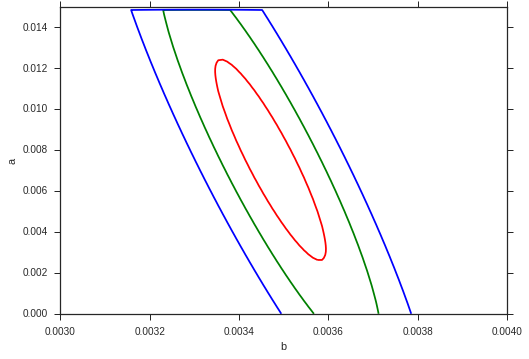

In [12]:
# First we assign all three variables to their own 2D arrays:
X, Y = np.meshgrid(bval,aval)
#Z = np.exp(-ll)
Z = ll
levels = [llmin+0.5, llmin+2.0, llmin+4.5] # plots the 1, 2 and 3-sigma

# confidence contours
plt.figure()
ax = plt.contour(X, Y, Z, levels, colors = ('r', 'g', 'b'))
plt.xlabel('b')
plt.ylabel('a')
plt.show()

## A complete example: the Pedroni et al. pion scattering data from Vaughan

We will now run through a complete example of ML fitting using the Pedroni et al. pion scattering data from the Vaughan book.  The data is contained in the file `pedroni.dat`.  Important background information is in Appendix B.5 of the book, which is also scanned as a pdf available with this tutorial. 

In [13]:
#  First let's read in the data.  Use np.genfromtxt which can deal with NANs
pion = np.genfromtxt("pedroni.dat", dtype=np.float, skip_header=1, 
autostrip=True)
# and only include values for energies up to 313 MeV, as recommended
# in the book and by Pedroni et al.
pion_clean = pion[pion[:,0] <= 313.0]
eval = pion_clean[:,0]
cross = pion_clean[:,1]
crosserr = pion_clean[:,2]

Now from this point we need to define the (Breit-Wigner) model and proceed to fit it to the data to find the MLEs and their 1-sigma confidence intervals, as well as the goodness of fit of the model.  At the end, you should plot the data and model together, along with the data-minus-model residuals in a separate plot.

In [14]:
# First let's define our physical model, the Breit-Wigner formula:
def breitwigner(eval,gam0,E0,N):
    gam=gam0*np.sqrt(eval/130.)
    gamsq=np.power(gam,2)/4.
    return N*gamsq/(np.power((eval-E0),2)+gamsq)

In [15]:
p0 = [30., 130., 150.]  # Define starting values
ml_cfpars, ml_cfcovar = scipy.optimize.curve_fit(breitwigner, eval, cross, p0, sigma=crosserr)
err = np.sqrt(np.diag(ml_cfcovar))

print "gam0 = " + str(ml_cfpars[0]) + " +/- " + str(err[0])
print "E0 = " + str(ml_cfpars[1]) + " +/- " + str(err[1])
print "N = " + str(ml_cfpars[2]) + " +/- " + str(err[2])

### curve_fit does not return the minimum chi-squared so we must calculate that ourselves for the MLEs
### obtained by the fit, e.g. using our original ChiSq function 

minchisq = np.sum(np.power((cross-breitwigner(eval,ml_cfpars[0],ml_cfpars[1],ml_cfpars[2]))/crosserr,2))
print "Minimum Chi-squared = " \
+ str(minchisq) + \
" for " + str(len(eval)-len(p0)) + " d.o.f."

print "The goodness of fit is: ",scipy.stats.chi2.sf(minchisq,df=33)

gam0 = 110.227040335 +/- 0.37736748003
E0 = 175.820914857 +/- 0.180325070235
N = 205.022250975 +/- 0.525305417074
Minimum Chi-squared = 38.012956708 for 33 d.o.f.
The goodness of fit is:  0.251586867489


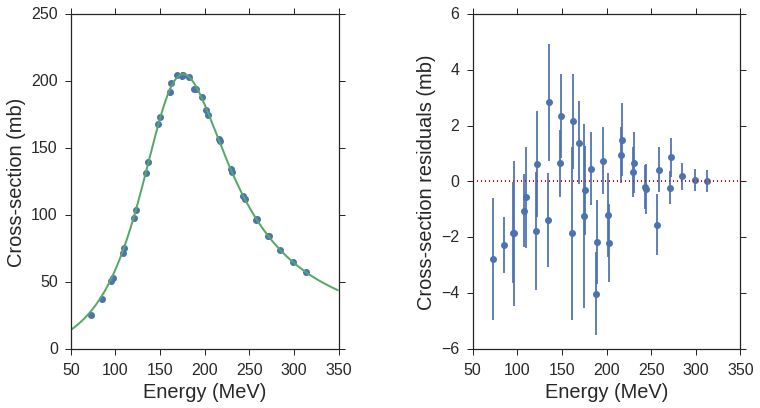

In [16]:
modeval = np.arange(50.0,350.0,1.0)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6)); plt.subplots_adjust(wspace=0.5)
ax1.errorbar(eval, cross, yerr=crosserr, marker="o", linestyle="")
ax1.plot(modeval, breitwigner(modeval,ml_cfpars[0],ml_cfpars[1],ml_cfpars[2]), lw=2)
ax1.set_xlabel("Energy (MeV)", fontsize=20)
ax1.set_ylabel("Cross-section (mb)", fontsize=20)
ax1.tick_params(labelsize=16)
ax2.errorbar(eval, cross-breitwigner(eval,ml_cfpars[0],ml_cfpars[1],ml_cfpars[2]), yerr=crosserr, 
             marker="o", linestyle="")
ax2.set_xlabel("Energy (MeV)",fontsize=20)
ax2.set_ylabel("Cross-section residuals (mb)", fontsize=20)
ax2.axhline(0.0, color='r', linestyle='dotted', lw=2) ## when showing residuals it is useful to also show the 0 line
ax2.tick_params(labelsize=16)
plt.show()

## Dealing with binned data

So far we have only considered fitting models to data where the data points represent single precisely known values of the explanatory variable (e.g. from experiments where this can be controlled, such as the energy of pions in the experiment of Pedroni et al., or the pressure gradient in Reynold's experiment).  However, it is often the case that our data is drawn from some distribution which we would like to fit a model to, and in this case the explanatory variable (i.e. plotted on the <i>x</i>-axis) is not something we control, but rather something we count and plot using a histogram.  In other words, these types of data need to be <i>binned</i> according to their $x$-values, with the <i>y</i>-values corresponding to the counts per bin, or (if the bins are arbitrary and we are fitting some continuous function to explain the data) some normalised version such as the counts per unit <i>x</i>-value (i.e. counts divided by the bin width).

Common examples of binned data include distributions of some variable drawn from an underlying population, such as the mass of stars in a cluster.  Another very common type of binned data is when we obtain a <i>spectrum</i>, e.g. plotting energy (or equivalent) on the <i>x</i>-axis versus e.g. number photons per unit energy, or versus events per unit energy if we are measuring a spectrum of events from a particle collider.  

Dealing with binned data raises some questions: <i>how should we choose to bin the data, and how do we assign an error bar to each bin?</i> And <i>how do we model data which is arbitrarily binned with a continuous function?</i>  Here we will look at how to deal with these issues, using as an example a simulated photon spectrum.  The file `photon_energies.txt` contains a list of 1054 measured photon energies simulated to represent a power-law distributed spectrum typical of those obtained by high-energy photon detectors from astronomical sources or particle colliders (if the photons are 'events').  The energies themselves are arbitrary here, but real detectors might cover ranges of keV, MeV or even GeV or higher.

In [17]:
###  First read in the data.  This is a simple (single-column) list of energies:
photens = np.genfromtxt('photon_energies.txt')
### The energy range covered by the detector is 10-200 GeV.  To start with, we can plot the spectrum using
### the matplotlib histogram routine:
nbins = 50
emin=10.0
emax=200.0
fig, ax1 = plt.subplots(1,1,figsize=(6,6))
counts, edges, patches = ax1.hist(photens, bins=50, range=[emin,emax], normed=False)
ax1.set_xlabel("Energy (GeV)", fontsize=20)
ax1.set_ylabel("Counts per bin", fontsize=20)
#ax1.set_yscale('log')
#ax1.set_xscale('log')
ax1.set_ylim(0.3,300.0)
ax1.set_xlim(10.0,200.0)
plt.show()

IOError: photon_energies.txt not found.

To better see the spectral shape (and infer that it is probably a power-law), you should plot this spectrum on a log-log scale (just uncomment the appropriate commands in the box above).  Note that you should always consider the best scale to use for your plots.  If there is a wide range of data values (e.g. factor 10 or more) a log scale may be more appropriate.  This may also be the case if you want to reveal the shape of your spectrum: different combinations of log and linear axes can reveal power-laws (for log-log) or exponential functions (for log-linear) as straight lines on the plot.  In general, bear in mind that plotting on linear or log scales may either distort or hide the true shape, and you should use whatever scale is appropriate to your data and what you are trying to show with the plot (of course, zero values do not work well in a log scale, but the axis limits may be chosen to avoid that problem if the plotting package you use does not automatically deal with it!).

### Choice of binning: getting towards normally distributed errors

Looking at the histogram above we see that at high energies where there are few photons, the spectrum gets quite noisy. Perhaps we should use wider bins to collect more counts per bin and so reduce the scatter?  However, if we use bins that are all the same width in energy units, by making the bins wider we may also distort and obscure the shape of the spectrum at lower energies, where it changes more rapidly per unit energy.  We could consider bins which are geometrically spaced, getting wider with increasing energy.  However, since we are trying to understand the spectrum and not necessarily assume any shape or binning, it is better to let the data guide us and decide on the binning according to the errors on the data in each bin.  That way, we can reduce the scatter by ensuring that the expected error on each bin has some minimum value.

In fact, there is some additional value to binning in this way: each bin records a number of <i>counts</i>, which follows a Poisson distribution.  The more counts in a bin, the closer the distribution of counts in that bin approximates a normal distribution (i.e., if we repeatedly sampled the bin in different experiments, the resulting value would be Poisson distributed but become closer to normal with more counts in the bin).  This means that for low counts in a bin, the errors <i>are not normally distributed</i>, but for high counts in the bin the errors <i>are effectively normally distributed</i>, which has the advantage that we can use weighted-least-squares to fit the spectrum (and assume chi-squared for our likelihood statistic) further on in our analysis.

What is the minimum counts per bin we should require?  It depends on how accurate you need your errors and tests to be.  The cell below can be used to compare the Poisson distribution for a given rate parameter (equal to the expected number of counts in a bin) with a normal distribution with the same mean and standard deviation (equal to $\sqrt(counts)$).    

In [ ]:
rpar = 20.  ###  Set rate parameter
p = scipy.stats.poisson(rpar)
mu = rpar
sigma = np.sqrt(rpar)
n = scipy.stats.norm(mu, sigma)
## Plot the normal probability density and Poisson probability mass functions
fig, ax1 = plt.subplots(1,1,figsize=(6,6))
xmin = mu-3.0*sigma
xmax = mu+3.0*sigma
xn = np.arange(xmin, xmax, sigma*0.1)
xp = np.arange(round(xmin), round(xmax), 1.0)
ax1.plot(xn, n.pdf(xn), lw=2, color='red')
ax1.step(xp, p.pmf(xp), lw=2, color='black', where='post')
ax1.set_xlabel("x", fontsize=20)
ax1.set_ylabel("probability density or mass", fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
plt.show()

In some fields, e.g. X-ray astronomy, the recommended minimum is 20 counts per spectral bin.  If you set the rate parameter above to equal 20, you can see that although the distribution is fairly similar to the normal distribution, it still differs significantly in the wings.  However, for most analyses this won't be a problem - it could become an issue if you want to assign an accurate significance to a feature which appears in one or two few bins at a few sigma level though.  Our recommendation therefore is that you consider 20 counts per bin as the absolute minimum required before you can assume normally distributed errors from that bin.

Now lets consider making our spectrum again.  Since making the spectrum need not be connected to plotting it, we will find it useful to use the specific numpy histogram for making a histogram, `numpy.histogram`.  The code in the following cell will make the histogram, but we also wish to rebin it by combining adjacent bins until the new bin contains at least 20 counts, so also we provide a function to do the rebinning:

In [ ]:
def histrebin(mininbin,counts,edges): # rebins a histogram so there are at least mininbin counts per bin

    edges2=np.zeros(1)
    counts2=np.zeros(1)
    i=0
    countsum=0
    firstbin_flag = 1
    edges2[0]=edges[0]
    for x in counts:
        countsum=countsum+x
        i=i+1
        if countsum >= mininbin and (sum(counts[i:]) >= mininbin or i == len(counts)):  # The sum over counts in 
            # remaining bins ensures that we are not left with a bin with counts less than our limit at the end.
            if firstbin_flag == 1: # if this is the first bin satisfying our requirement, 
                # do not append but replace bin 0 with countsum
                counts2[0]=countsum
                firstbin_flag = 0 # now we read the first bin we can switch this off
            else:
                counts2=np.append(counts2,countsum)
            edges2=np.append(edges2,edges[i])
            countsum=0        

    return counts2, edges2

### Now we make our unbinned histogram.  We can keep the initial number of bins relatively large.
nbins = 50
counts, edges = np.histogram(photens, bins=nbins, range=[emin,emax], density=False)

### And now we use our new function to rebin so there are at least mincounts counts per bin:
mincounts = 20  # Here we set it to our minimum requirement of 20, but in principle you could set it higher
counts2, edges2 = histrebin(mincounts,counts,edges)

Before we look again at our spectrum, we should also correct it for the bin-widths (which are now different between bins) and also assign errors to each bin.  Dividing the counts by the bin-width to get a <i>count density</i> - or sometimes <i>flux density</i> - converts all bins to a common scale so that the arbitrary choice of bin width does not matter (it can also allow a direct comparison, but for the fitting we need to be more careful, see later...).  

The errors are Poissonian - in other words the standard error on the counts in a bin is $\sqrt{n}$ where $n$ is the number of counts (see the lecture slides from Week 3 and also Week 5 where the variance on the Poisson rate parameter MLE is derived).  

In [ ]:
bwidths = np.diff(edges2) # calculates the width of each bin
cdens = counts2/bwidths # determines the count densities
cdens_err = np.sqrt(counts2)/bwidths # calculate the errors: remember the error is based on the counts, 
# not the count density, so we have to also apply the same normalisation.

Now we have our spectrum, we can plot it.  In `matplotlib` this could be done using a stepped plot but it is difficult to get the binning right when the bins are different sizes.  Bespoke spectral-fitting packages will offer their own tools for plotting, and conventions may vary, but here we will show one of the common approaches.  It is common to use data points with both x- and y-error bars to display spectral data, even where the bins are contiguous.  The x-errors indicate the bin size but are not used for model-fitting purposes.

In [ ]:
energies = (edges2[:-1]+edges2[1:])/2.  # This calculates the energy bin centres

fig, ax1 = plt.subplots(1,1, figsize=(6,6))
ax1.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o')
ax1.set_xlabel("Energy (GeV)", fontsize=20)
ax1.set_ylabel("Counts/GeV", fontsize=20)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim(0.3,300.0)
ax1.set_xlim(10.0,200.0)
plt.show()                                      

The data may look like it contains some sort of 'emission' features on top of the power-law, but don't be fooled!  Such features on a log-scale can appear deceptively strong, and we also expect to see some deviations from the expected continuum when we plot a large number of bins.  Instead, we must be guided by our model fits and carry out hypothesis testing using the likelihood ratio to see if these features are real (see the Week 6 tutorial for more on this).

### Fitting binned data with a continuous function

Now we have our spectrum and we think our errors are close to normally distributed, we should be able to fit models to our data.  It is important to bear in mind that for almost all types of binned data you will encounter, the models will themselves be continuous - e.g. there is no reason to suspect that energies arise with discrete values.  E.g. even distinct spectral line features from atomic or nuclear transitions will be superimposed on some continuum, even if it is just an instrumental or 'sky' background, and in any case most spectral lines will have a finite width due to either physical line-broadening processes or the intrinsic resolution of the detector. 

With this in mind, we need to think about how to fit binned data with a continuous model function.  Previously, we assumed that our data points represented single points along the continuous function.  Now, we must consider that our counts in a given bin are sampled from the function across all energies in that bin.  The solution therefore is to <i>integrate the model over the energy range of the bin</i>.  There are several ways to do this:  

1.  The indefinite integral function may be calculated explicitly and used directly as the model function.  This is easy to do for a simple function such as a power-law, but may be difficult for more complicated or challenging functions. 
2.  Python offers numerical methods to calculate the definite integral for a given function (e.g. in `scipy.integrate`).
3.  If you are fitting a model which is itself a statistical distribution in Python, you could use the cdf of the distribution to determine the integral between two values.  Note that in this case you may have to scale the distribution accordingly, to match your spectrum (e.g. the integral of the pdf would no longer be 1.0, but would be the total number of counts in the spectrum).

Let's now consider a generic set-up for calculating weighted-least-squares, which calculates the integral of an input function numerically across a given range of <i>x</i>-values.  This function makes use Python's capability to work with generic 'lambda' functions, where any given function and its parameters (`fparm` in this case) can be substituted in:

In [ ]:
def ChiSq_Integ(parm, ebins, yval, dy): # the weighted least-squares for an array of upper and lower bin edges
    # (xval1 and xval2) fitted with the integral over the bin of the generic model my_fit_model
    i = 0
    ymod = np.zeros(len(yval))
    for energy in ebins[:-1]:
        ymod[i], ymoderr = scipy.integrate.quad(lambda x: my_fit_model(x, parm),ebins[i],ebins[i+1])
        ymod[i] = ymod[i]/(ebins[i+1]-ebins[i])  # we now divide by the bin width to match the counts density
        # units of our data
        i=i+1

    return sum(pow((yval-ymod)/dy,2))

And we define `my_fit_model` as a simple power-law, noting that in this case, we could also have worked out the indefinite integral and used that function with our simpler weighted-least-squares function from earlier:

In [ ]:
def my_fit_model(value, fparm):
    pl_norm = fparm[0]  # here the function given means that the normalisation corresponds to that at a value 1.0
    pl_index = fparm[1]
    return pl_norm * np.power(value,pl_index)

This type of approach would be useful if we wanted to use some generic minimisation routine in Python, where we minimise the `ChiSq_Integ` function.  Alternatively, if we want to use `curve_fit` we have to allow for the fact that `curve_fit` already does the weighted-least-squares calculation for us, so we must already do the integration in the model.  It's straightforward to guess the starting parameters from the appearance of the data on the plot.  We can use the `ChiSq_Integ` function we have defined with `fmin_bfgs` however, as before.  Fortunately, the method works well with this model and data:

In [ ]:
fparm = [2500.0, -1.5]
ml_pars, ml_funcval, ml_grad, ml_covar, func_calls, grad_calls, warnflag = \
scipy.optimize.fmin_bfgs(ChiSq_Integ, fparm, args=(edges2, cdens, cdens_err), full_output=True)

print ml_pars, ml_funcval

In [ ]:
err = np.sqrt(np.diag(ml_covar))
print "Normalisation at 1 GeV = " + str(ml_pars[0]) + " +/- " + str(err[0])
print "Power-law index = " + str(ml_pars[1]) + " +/- " + str(err[1])
print "Minimum Chi-squared = " + str(ml_funcval) + " for " + str(len(cdens)-len(fparm)) + " d.o.f."
print "The goodness of fit is: " + str(scipy.stats.chi2.sf(ml_funcval,df=(len(cdens)-len(fparm))))

Clearly the power-law model is an acceptable fit!  Of course you should also plot the data versus model and residuals, which we leave as an exercise to the reader (note: a step-plot would be a good way to plot the model, but this will take some work to figure out - a basic line plot would be acceptable as an easier alternative).

## An alternative to rebinning: fitting using the Poisson distribution

In some cases we may not want to rebin our data to achieve at least 20 counts per bin.  Perhaps we want to preserve the resolution of our data to take the opportunity to look for narrow features at energies where the counts are sparse (such features may be smeared out if we use wide bins, but could be significant if several counts appear close together in energy).  Or perhaps we don't care about getting a goodness-of-fit and therefore don't want to use weighted-least-squares as our likelihood statistic.  In these cases an alternative option will be to use the Poisson distribution to generate our likelihood function, so we do not care whether there are sufficient counts in a bin (or even if the bins are empty: with a Poisson distribution having zero counts in a bin is possible for small rate parameters and therefore conveys useful information!).

In [ ]:
def LogLikelihood_Pois_Integ(parm, ebins, yval): # the -ve log-likelihood or an array of bin edges, fitted with 
    # the integral over the bin of the generic model my_fit_model.  Input yval must be counts and not counts per
    # unit x-value
    i = 0
    ymod = np.zeros(len(yval))
    for energy in ebins[:-1]:
        ymod[i], ymoderr = scipy.integrate.quad(lambda x: my_fit_model(x, parm),ebins[i],ebins[i+1])
        # we don't normalise by bin width since the rate parameter is set by the model and needs to be counts per bin
        i=i+1
        
    pd = scipy.stats.poisson(ymod) #we define our Poisson distribution

    return -sum(np.log(pd.pmf(yval)))

fparm = [2500.0, -1.5]

### We use our original counts bins.  Also, remember that the Likelihood function we have just defined uses 
### counts rather than count density
ml_pars, ml_funcval, ml_grad, ml_covar, func_calls, grad_calls, warnflag = \
scipy.optimize.fmin_bfgs(LogLikelihood_Pois_Integ, fparm, args=(edges, counts), full_output=True)

print ml_pars, ml_funcval

err = np.sqrt(np.diag(ml_covar))
print "Normalisation at 1 GeV = " + str(ml_pars[0]) + " +/- " + str(err[0])
print "Power-law index = " + str(ml_pars[1]) + " +/- " + str(err[1])
print "Maximum log-likelihood = " + str(-1.0*ml_funcval)

We can see that using the full data with no extra rebinning gives similar results to fitting the binned data using weighted least-squares.  The differences may be due to the fact that in the non-rebinned data we effectively have more information where photons are sparse at higher energies.  Also, it could be because our rebinned data errors were not exactly normally distributed.  Formally the log-likelihood with the Poisson distribution is the 'most correct' even if it is not always the most practical method.

Again, you should try plotting the data versus the model.  Residuals can also be plotted but these would be without error bars, although it would be reasonable to approximate errors for visual purposes using the known $\sqrt{n}$ standard error on the model.  In fact, in some sense it is more realistic to assume here that the 'error bar' is on the model value of the counts per bin, which is itself an MLE for the rate parameter, rather than the binned counts from the data (which is the usual convention).  Therefore you could try using as an error bar the error derived from the best-fitting model counts in each bin, which you could return by modifying the LogLikelihood function above.